In this notebook we will implement the calculation of **CONSTANT HEIGHT STM IMAGES**.


The equations
--------------

Using the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998), **the tunneling current is proportional to the local density of states** at a certain point close to the material:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$

The LDOS at a certain energy is simply described as the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy:

$$
LDOS(r, E) = \sum_{i} n(E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})  
$$

Where $n(E, \epsilon)$ is the occupation function that determines the contribution of a given wavefunction. $E$ is the energy for which we want the LDOS and $\epsilon_i$ is the energy of the wavefunction. One possible occupation function is Dirac's delta:

$$
n(E, \epsilon) = \delta(E - \epsilon) = 
\begin{cases}
  1, & \text{if}\ E = \epsilon \\
  0, & \text{otherwise}\
\end{cases}\,.
$$

In summary, to compute constant height STM images. We need to:
- Get a Hamiltonian (we will use SIESTA for this).
- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies).
- Implement a function that computes the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ at a given voltage $V$. The full equation is:

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

- Take the points of space of a given plane (at constant height), as an STM tip would do.

In this first case, we will **compute STM images of a benzene molecule**.

Tips
------

**To build the molecule:**

You can use the `ase` (Atomic Simulation Environment) python package. It has a function `ase.build.molecule` that can generate a benzene molecule. Look at its documentation (https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.molecule) to understand how to use it. Add at least 5 Ang of vacuum!

**To write the molecule to a file:**

`ase` will give you an `ase.Atoms` object. You can convert it to `sisl` with `sisl.Geometry.new(ase_atoms)`. Then you can write it to an fdf file as usual.

Plot the molecule before writing it to make sure that it is what you expect.

**To run the SIESTA calculation:**

You will need the Hamiltonian, so don't forget to tell siesta to store it in a `.TSHS` file by using `TS.HS.Save true`.

**To read the Hamiltonian:**

Once the SIESTA run has finished, you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid(geometry, shape=(100, 100, 100))`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.

Remember that we have done this already on the first SIESTA lab, with a water molecule.

**To plot the STM images at a certain height:**

A function is provided to plot molecules at multiple heights. You can use it as it is or modify it as you wish.

*Note*: If you have time, you can modify this function to create a plots at multiple voltages. Even a grid of plots at multiple voltages and multiple heights!

**To check that things make sense:**

You can plot all the eigenstates of your system to try to understand if the STM images make sense with something like:

```python
H.plot.pdos(data_Erange=[-10, 10], nE=1200, Erange=[-10, 10], kgrid=[1,1,1]).split_DOS(on="species+l+m")
```

Helper: Grids have a `fill` method to set all the values of the grid to a given value, if that is needed.

Let's get to work
---------------

From now on, you have to implement the STM images! 

Look at the equation for current and try to think how that can be translated into code. If you get stuck, experiment with whatever ideas you have! There's no harm in making python error, you won't break it ;)

**Some imports:**

In [1]:
import sisl
import sisl.viz
import numpy as np
from ase.build import molecule

In [2]:
atoms = molecule('C6H6')
geometry = sisl.Geometry.new(atoms)

In [3]:
geometry.write("geom.fdf")

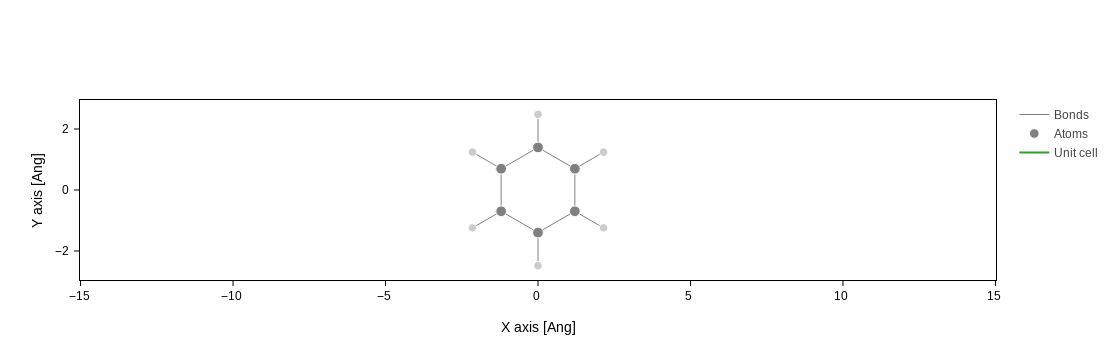

In [4]:
geometry.plot(axes="xy")

In [5]:
H = sisl.get_sile("/home/samba/homes/convidat/Desktop/su/geom.fdf").read_hamiltonian()
print(H)

Hamiltonian{non-zero: 11658, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 12, no: 108,
  Atoms{species: 2,
   Atom{C, Z: 6, mass(au): 12.01000, maxR: 2.61070,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.1742000000000092, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.7378999999999991, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.590900000000002, q0: 2.0}},
    AtomicOrbital{2pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.590900000000002, q0: 2.0}},
    AtomicOrbital{2pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 2.590900000000002, q0: 2.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7725999999999997, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7725999999999997, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.7725999999999997, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2

In [6]:
v = H.eigenstate()
v.eig

array([-16.8539953 , -14.08629907, -14.08621609, -10.53398739,
       -10.53383518,  -8.66222898,  -6.89488701,  -6.66850871,
        -5.95266049,  -5.95200747,  -4.75515922,  -3.95330382,
        -3.95307687,  -2.02796088,  -2.02775261,   3.1735277 ,
         3.17368258,   6.09451279,   7.11157982,   7.60688426,
         7.60754124,   8.38576148,   8.38583514,   9.13802477,
        11.23017   ,  11.23096814,  11.42652335,  11.42696027,
        11.80788569,  12.21677547,  12.4519291 ,  14.52743099,
        14.52782982,  15.06016953,  15.06087899,  15.50333425,
        16.05012005,  16.05173839,  17.01116429,  17.2372295 ,
        17.47083374,  17.47103176,  18.03624494,  19.26208104,
        19.90288332,  21.94906244,  21.95015584,  22.04473396,
        22.04599084,  22.11054383,  22.11062187,  23.83009334,
        23.83028115,  24.67722743,  24.93616946,  24.9379276 ,
        25.90987159,  26.85617846,  26.85684055,  27.19691593,
        27.50301548,  28.21877135,  28.2194185 ,  29.59

In [16]:
grid = sisl.Grid((100,100,100),geometry=geometry)
grid.plot( axes='xy')

In [ ]:
suma = 0
for i in v:
    wf = sisl.physics.electron.wavefunction(i, grid, geometry=None, k=None, spinor=0, spin=None, eta=None)
    wf_ = np.conj(wf)
    multi = np.multiply(wf,wf_)
    suma = np.sum(suma, multi)
    suma
    

In [9]:
sisl.physics.electron.wavefunction(v, grid, geometry=None, k=None, spinor=0, spin=None, eta=None)

info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information

info:0: SislInfo:

wavefunction: summing 108 different state coefficients, will continue silently!



LinAlgError: Singular matrix

In [ ]:
for eig in eigenstate:
    

**The helper function to plot STM images once you have the LDOS grid:**

In [ ]:
# The helper function
def plot_STM_images(
    LDOS_grid: sisl.Grid, 
    min_height: int = 0, 
    max_height: int = 2,
    steps: int = 9,
    crange = None,
    colorscale: str = None
):
    """Plots constant height STM images at multiple heights

    Parameters
    ----------
    LDOS_grid:
        A grid containing the LDOS corresponding to the voltage that you
        want to plot, for ALL SPACE.
    min_height:
        The height of the first image.
    max_height:
        The height of the last image.
    steps:
        The number of steps between the first and the last image.
    log:
        Whether to plot the log of the values.
    crange:
        The range of the colorscale. E.g. [0, 2]. If None, it is computed
        from the minimum and maximum values of the data.
    colorscale:
        The plotly colorscale to use.

    Examples
    ----------

    This function should be used like:
    >>> grid = ...compute the LDOS in the grid.
    >>> plot_STM_images(grid)
    """

    # Determine all the heights that the user wants to plot
    heights = np.linspace(min_height, max_height, steps)
    # Get the position of the benzene molecule
    z_0 = grid.geometry.xyz[:, 2].max()
    
    # Initialize a list of plots
    plots = []
    coloraxes = []
    # Loop through the heights, and for each of them we will create a plot.
    for height in heights:
        # Get the z for which we want the LDOS (benzene position + height)
        z = z_0 + height
        
        # Get the plot for this height
        plot = LDOS_grid.plot(axes="xy", z_range=[z - 0.1, z + 0.1], crange=crange, colorscale=colorscale)

        # And append it to the list
        plots.append(plot)

    # Merge all the plots, with some extra arguments to beautify the plot.
    return sisl.viz.merge_plots(
        *plots, 
        composite_method="subplots", 
        arrange="square", 
        subplot_titles=[f"Height = {height} Ang" for height in heights],
        horizontal_spacing=0,
        vertical_spacing=0.05
    ).update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=900, title=f"Constant height STM images",
    )

**A function skeleton:**

Thinking of things as a function helps you understand what you expect to get as an input and what you are expected to produce as an output. Here is a skeleton that might help you with your implementation:

In [ ]:
def LDOS_grid(H, V):
    """Computes the LDOS in a grid.

    Parameters
    ----------
    H:
        the Hamiltonian of the system
    V:
        the voltage for which you want the LDOS.
    """

    grid = #...compute grid

    return grid

This function contains the basic arguments, of course you could add more inputs to allow the user to further tweak the functionality.

**Your place to work:**